# Project for People's Daile - Part #[5.3]
## Time Path with Word2Vec

In [1]:
import dask
import copy
import numpy as np
import pandas as pd
import seaborn
import gensim
import dask
from gensim.models.word2vec import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib as mpl
from functools import reduce

In [2]:
dask.config.set(scheduler='threads')

# from dask.distributed import Client
# client = Client()
# client

In [3]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.vectors / np.sqrt((model.wv.vectors ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    
    base_embed.init_sims()
    other_embed.init_sims()
#     base_embed = copy.copy(base_embed)
#     other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

@dask.delayed        
def alignModel_year(catOuter, cats, full=False): 
    embeddings_raw = {}
    for year in cats:
        if full:
            embeddings_raw[year] = Word2Vec.load(f'models/Word2Vec&Doc2Vec/rmrb_{year}_W2V_full')
        else:
            embeddings_raw[year] = Word2Vec.load(f'models/Word2Vec&Doc2Vec/rmrb_{year}_W2V')
    embeddings_aligned_year = [embeddings_raw[catOuter]]
    for catInner in cats: 
        embeddings_aligned_year.append(
            smart_procrustes_align_gensim(
                embeddings_aligned_year[-1], 
                embeddings_raw[catInner]
            )
        )
    return (
        embeddings_aligned_year, 
        f'{catOuter} completed Procrustes aligning. '
    )


def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - cosine_similarity(
                np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                np.expand_dims(embed.wv[word], axis = 0)
            )[0,0]))
    return pd.DataFrame(dists, index=cats)

In [21]:
# create a function to generate the dictionary of nearest words
def get_dists_dict(TargetWord, cats, embeddings_raw, embeddings_aligned):
    common_words = reduce((lambda x, y: x & y), [embeddings_raw[year].wv.vocab.keys() for year in cats])  
    dists_dict = {}
    for year in cats:  
        temp_dict = {}
        model = embeddings_aligned[2002][year - cats[0] + 1]
        for word in common_words:  
            temp_dict[word] = cosine_similarity(np.expand_dims(model.wv[word], axis=0), 
                                                np.expand_dims(model.wv[TargetWord], axis=0))[0, 0]
        temp_dict = dict(sorted(temp_dict.items(), key=lambda w: w[1], reverse=True)[:20])
        for top_word in temp_dict.keys():
            if top_word:
                dists_dict[top_word + f'({year})'] = model.wv[top_word]
    return dists_dict

### Economics and politics corpus

In [151]:
cats_mkt_sub = [year for year in range(1978, 2003)]

In [153]:
%%time
embeddings_aligned_mkt_sub = {}
for a in range(5): 
    delayed_funcs = []
    for catOuter in cats_mkt_sub[a * 5: (a + 1) * 5]: 
        delayed_funcs.append(alignModel_year(catOuter, cats_mkt_sub))
    for ind, response in enumerate(dask.compute(*delayed_funcs)): 
        embeddings_aligned_mkt_sub[cats_mkt_sub[a * 5: (a + 1) * 5][ind]] = response[0]
        print(response[1])

1978 completed Procrustes aligning. 
1979 completed Procrustes aligning. 
1980 completed Procrustes aligning. 
1981 completed Procrustes aligning. 
1982 completed Procrustes aligning. 
1983 completed Procrustes aligning. 
1984 completed Procrustes aligning. 
1985 completed Procrustes aligning. 
1986 completed Procrustes aligning. 
1987 completed Procrustes aligning. 
1988 completed Procrustes aligning. 
1989 completed Procrustes aligning. 
1990 completed Procrustes aligning. 
1991 completed Procrustes aligning. 
1992 completed Procrustes aligning. 
1993 completed Procrustes aligning. 
1994 completed Procrustes aligning. 
1995 completed Procrustes aligning. 
1996 completed Procrustes aligning. 
1997 completed Procrustes aligning. 
1998 completed Procrustes aligning. 
1999 completed Procrustes aligning. 
2000 completed Procrustes aligning. 
2001 completed Procrustes aligning. 
2002 completed Procrustes aligning. 
Wall time: 1min 39s


In [155]:
embeddings_raw_mkt_sub = {}
for year in cats_mkt_sub: 
    embeddings_raw_mkt_sub[year] = Word2Vec.load(f'../models/Word2Vec&Doc2Vec/filtered_corpus/rmrb_{year}_W2V')

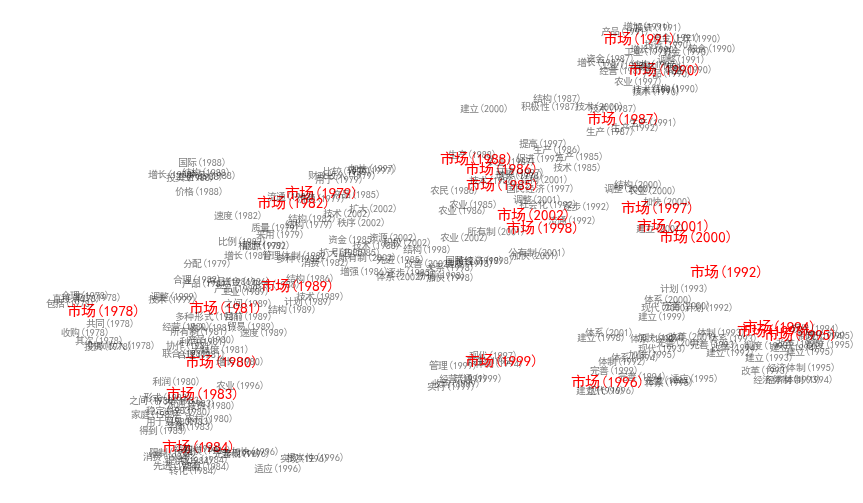

In [183]:
# path for "market"
dists_dict_mkt_sub = get_dists_dict('市场', cats_mkt_sub, embeddings_raw_mkt_sub, embeddings_aligned_mkt_sub)

VisWordsSubMatrix = []
for vector in dists_dict_mkt_sub.values():
    VisWordsSubMatrix.append(vector)
VisWordsSubMatrix = np.array(VisWordsSubMatrix)

TSNEmodel = TSNE(n_components=2, random_state=25, init='pca')
TSNEfitted = TSNEmodel.fit_transform(VisWordsSubMatrix)

mpl.rcParams['font.sans-serif'] = ['SimHei']

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(TSNEfitted[:, 0], TSNEfitted[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(dists_dict_mkt_sub.keys()):
    if '市场' in word:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='r', size=15)
    else:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='black', alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.show()

In [157]:
cats_mktecon_sub = [year for year in range(1992, 2003)]

In [158]:
%%time
embeddings_aligned_mktecon_sub = {}
delayed_funcs = []
for catOuter in cats_mktecon_sub: 
    delayed_funcs.append(alignModel_year(catOuter, cats_mktecon_sub))
for ind, response in enumerate(dask.compute(*delayed_funcs)): 
    embeddings_aligned_mktecon_sub[cats_mktecon_sub[ind]] = response[0]
    print(response[1])

1992 completed Procrustes aligning. 
1993 completed Procrustes aligning. 
1994 completed Procrustes aligning. 
1995 completed Procrustes aligning. 
1996 completed Procrustes aligning. 
1997 completed Procrustes aligning. 
1998 completed Procrustes aligning. 
1999 completed Procrustes aligning. 
2000 completed Procrustes aligning. 
2001 completed Procrustes aligning. 
2002 completed Procrustes aligning. 
Wall time: 27.7 s
Parser   : 149 ms


In [159]:
embeddings_raw_mktecon_sub = {}
for year in cats_mktecon_sub: 
    embeddings_raw_mktecon_sub[year] = Word2Vec.load(f'../models/Word2Vec&Doc2Vec/filtered_corpus/rmrb_{year}_W2V')

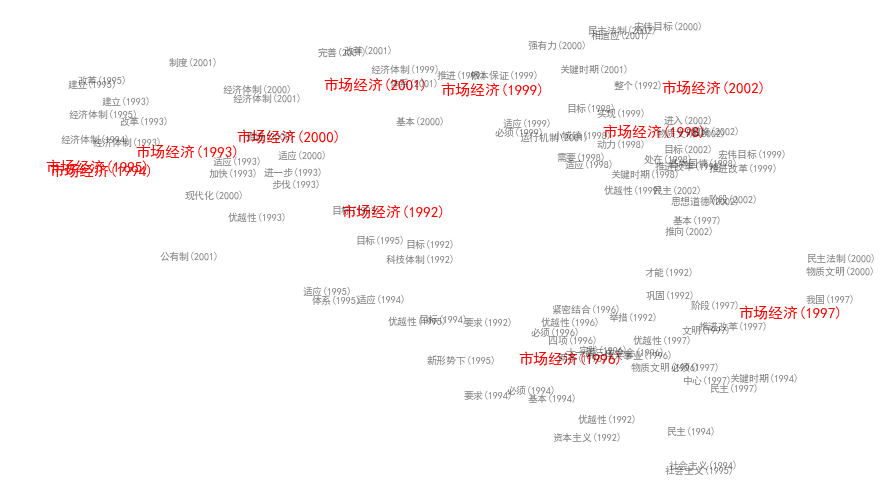

In [184]:
# path for "market"
dists_dict_mktecon_sub = get_dists_dict('市场经济', cats_mktecon_sub, 
                                        embeddings_raw_mktecon_sub, embeddings_aligned_mktecon_sub)

VisWordsSubMatrix = []
for vector in dists_dict_mktecon_sub.values():
    VisWordsSubMatrix.append(vector)
VisWordsSubMatrix = np.array(VisWordsSubMatrix)

TSNEmodel = TSNE(n_components=2, random_state=0, init='pca')
TSNEfitted = TSNEmodel.fit_transform(VisWordsSubMatrix)

mpl.rcParams['font.sans-serif'] = ['SimHei']

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(TSNEfitted[:, 0], TSNEfitted[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(dists_dict_mktecon_sub.keys()):
    if '市场经济' in word:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='r', size=15)
    else:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='black', alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.show()

In [5]:
# user = input("Who is using the notebook? ")
# if user == "Tim":
#     print("To be updated")
# elif user == "Linghui":
#     print("To be updated")
# elif user == "Minghao":
#     filtered_corpus_name = "C:/Users/Thinkpad/ContentAnalysis/EconContent/data/filtered_corpus_by_year/"
#     full_corpus_name = "C:/Users/Thinkpad/ContentAnalysis/EconContent/data/full_corpus_by_year/"
# elif user == "Minghao_RCC":
#     filtered_corpus_name = "/home/mhyang/EconContent/data/filtered_corpus_by_year/"
#     full_corpus_name = "/home/mhyang/EconContent/data/full_corpus_by_year/"

Who is using the notebook? Minghao


In [6]:
# %%time
# for year in range(1965, 2003):
#     corpus = []
#     with open(full_corpus_name + "{}.txt".format(year), encoding='utf-8') as f:
#         for line in f:
#             tokens = line.split(' ')
#             tokens.remove('\n')
#             corpus.append(tokens)
#     model = Word2Vec(corpus, size=200, window=10, min_count=5, workers=8, seed=0)
#     model.save('../models/Word2Vec&Doc2Vec/full_corpus/rmrb_{}_W2V_full'.format(year))

Wall time: 17min 33s


### Full corpus

In [5]:
cats_mktecon_full = [year for year in range(1984, 2003)]

In [10]:
%%time
embeddings_aligned_mktecon_full = {}
delayed_funcs = []
delayed_funcs.append(alignModel_year(2002, cats_mktecon_full, full=True))
response = dask.compute(*delayed_funcs) 
embeddings_aligned_mktecon_full[2002] = response[0][0]
print(response[0][1])      

2002 completed Procrustes aligning. 
Wall time: 33.8 s


In [11]:
embeddings_raw_mktecon_full = {}
for year in cats_mktecon_full: 
    embeddings_raw_mktecon_full[year] = Word2Vec.load(f'../models/Word2Vec&Doc2Vec/full_corpus/rmrb_{year}_W2V_full')

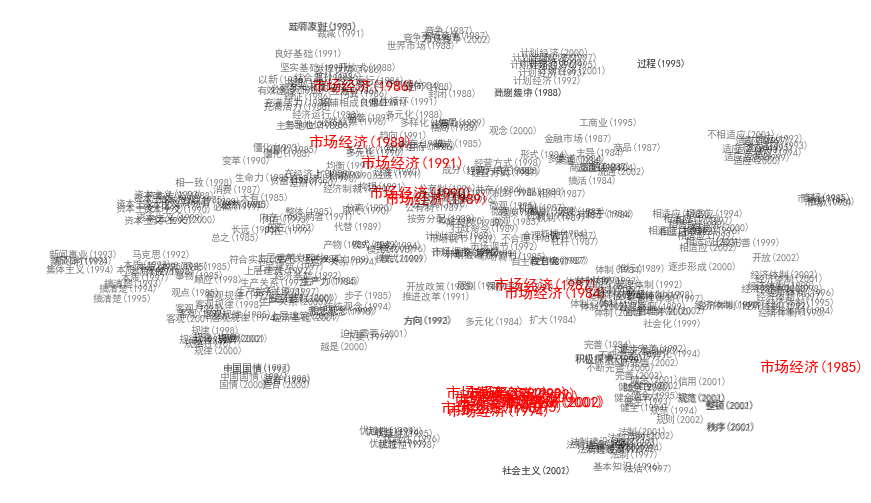

In [20]:
# path for "market"
dists_dict_mktecon_full = get_dists_dict('市场经济', cats_mktecon_full, 
                                         embeddings_raw_mktecon_full, embeddings_aligned_mktecon_full)

VisWordsSubMatrix = []
for vector in dists_dict_mktecon_full.values():
    VisWordsSubMatrix.append(vector)
VisWordsSubMatrix = np.array(VisWordsSubMatrix)

TSNEmodel = TSNE(n_components=2, random_state=0, init='pca')
TSNEfitted = TSNEmodel.fit_transform(VisWordsSubMatrix)

mpl.rcParams[u'font.sans-serif'] = mpl.rcParams[u'font.sans-serif'] + ['SimHei']

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(TSNEfitted[:, 0], TSNEfitted[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(dists_dict_mktecon_full.keys()):
    if '市场经济' in word:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='r', size=15)
    else:
        ax.annotate(word, (TSNEfitted[:, 0][i], TSNEfitted[:, 1][i]), color='black', alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.savefig('../pictures/dynamic_word2vec/time_path.png')
plt.show()